Based on _fredrikwahlberg_'s notebook

In [1]:
import numpy as np              # Vector math
import pytesseract              # OCR
import matplotlib.pyplot as plt # Plotting
import os
import pandas
%matplotlib inline

In [48]:
SAMPLEFONT = "gentium-r.ttf"
SAMPLETEXT = "Šámpľë text!\nŠámpľë text!\nŠámpľë text!\nŠámpľë text!"

In [60]:
IMGDIR = "assorted/imgout" # directory for storing rendered images
TXTDIR = "assorted/txtout" # directory for storing OCR'd text
FONTDIR = "fonts/assorted" # directory with font files
PTSIZE_LIST = [12,16,20,24,28] # list of font sizes to generate
COLORMODE = "gray" # BW or GRAY
TEXTFILE = "zprava.txt" # file with sample text
LANG = "ces" # Tesseract language model

os.makedirs(IMGDIR, exist_ok=True)
os.makedirs(TXTDIR, exist_ok=True)

# Set up functions

Here we set up functions to read font data, render text as images, OCR them and perform error metrics.

The following function extracts font name from a TTF or OTF file.

In [15]:
from fontTools.ttLib import TTFont

def get_font_name(fontfile):
    font = TTFont(fontfile)
    for record in font["name"].names:
        if record.nameID == 4:
            return record.toUnicode()
        
# Example
print(get_font_name(SAMPLEFONT))

Gentium Plus


The following two functions render given text using a given font file. `render_text_bw` produces an image of only black and white pixels. `render_text_gray` uses grayscale, so the image looks smoother.

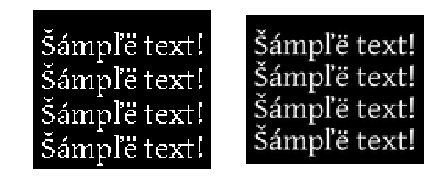

In [50]:
from PIL import ImageFont, ImageDraw, Image

def render_text_bw(texttorender, fontfile, ptsize=20, linespacing=0, as_array=True):
    font = ImageFont.truetype(fontfile, ptsize)
    # Create a dummy image, draw text and find out its size 
    pimg = Image.new('L', (1, 1))
    draw = ImageDraw.Draw(pimg)
    x,y = draw.textsize(texttorender, font=font, spacing=linespacing)
    # Create a new image large enough for the text
    pimg = Image.new('L', (x+10,y+14))
    draw = ImageDraw.Draw(pimg)
    draw.text((5,7), texttorender, fill=1, font=font, spacing=linespacing)
    if as_array:
        return np.array(pimg,dtype=np.uint8)
    return pimg

def render_text_gray(texttorender, fontfile, ptsize=20, linespacing=0, as_array=True):
    # To introduce the gray edges, we generate the text 
    # in a larger scale and then shrink it down.
    # We also need to use RGB, since PIL does not support grayscale mode 
    rf = 4 #resize factor
    ############
    font = ImageFont.truetype(fontfile, rf*ptsize)
    pimg = Image.new("RGB", (1, 1))
    draw = ImageDraw.Draw(pimg)
    x,y = draw.textsize(texttorender, font=font, spacing=rf*linespacing,)
    pimg = Image.new("RGB", (x+10*rf,y+15*rf))
    draw = ImageDraw.Draw(pimg)
    draw.text((5*rf,5*rf), texttorender, fill=(255,255,255), font=font, spacing=rf*linespacing)
    pimg_resized = pimg.resize((x//rf,y//rf), Image.ANTIALIAS)
    if as_array:
        return np.array(pimg_resized,dtype=np.uint8)[:,:,0]
    return pimg_resized

# Example
fig = plt.figure(figsize=(7, 7))
fig.add_subplot(1, 2, 1)
plt.axis('off')
plt.imshow(render_text_bw(SAMPLETEXT, SAMPLEFONT), cmap='gray')
fig.add_subplot(1, 2, 2)
plt.axis('off')
plt.imshow(render_text_gray(SAMPLETEXT, SAMPLEFONT), cmap='gray')
plt.show()

The grayscale image comes out a bit stretched for small sizes because of integer rounding that happens when it is resized. The stretch is negligible for larger texts, such as the one we use for our experiments later.

The following two functions serve for previewing fonts in a directory. 

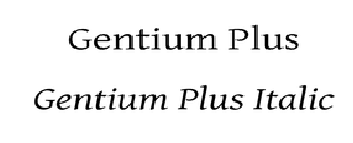

In [112]:
def get_fontdir_names(directory):
    fontnames = {}
    files = os.listdir(directory)
    for name in files:
        path = os.path.join(directory, name)
        if not (os.path.isfile(path) and name[-3:].lower() in ("otf","ttf")):
            continue
        fontnames[path] = get_font_name(path)
    return fontnames

def fonts_preview(fontdict):
    previews = []
    for file, name in fontdict.items():
        img = render_text_gray(name, file, 36)
        previews.append(255-img)

    fig = plt.figure(figsize=(12, len(previews)))
    for i in range(len(previews)):
        fig.add_subplot(len(previews), 1, i+1)
        plt.axis('off')
        plt.imshow(previews[i], cmap='gray')
    plt.show()

fonts_preview(get_fontdir_names("."))

<Figure size 864x864 with 0 Axes>

[]

The images came out stretched for some reason, but this does not happen with longer text.

The following code saves the images as png files if needed:

In [ ]:
IMGDIR = "img"

for fontfile in os.listdir(FONTDIR):
    fontpath = "/".join((FONTDIR,fontfile))
    outname = "{}/{}.png".format(IMGDIR, fontfile.split(".")[:-1][0])
    font = TTFont(fontpath)
    for record in font["name"].names:
        if record.nameID == 4:
            fontname = record.toUnicode()
            break
    img = render_text_gray((fontname+"\n")*4, 36, fontfile=fontpath, as_array=False)
    img.save(outname, dpi=(72,72))

## Prepare text

Read TEXTFILE and split long lines.

In [155]:
def breaklines(text, char_limit=60):
    settext = []
    for par in text.split("\n"):
        chunk = []
        chunk_len = 0
        for word in par.split(" "):
            if len(word) + chunk_len > char_limit:
                settext.append(" ".join(chunk))
                chunk = []
                chunk_len = 0
            chunk.append(word)
            chunk_len += len(word)
        splitpar = " ".join(chunk)
        if splitpar:
            settext.append(splitpar)
    return "\n".join(settext)

with open(TEXTFILE, 'r') as file:
    original_text = file.read()

original_text = breaklines(original_text)
print(original_text)

Facebook se brání kritice tak, že v nejlepším politickém stylu hledá
špínu na své oponenty. Dělá to však neobratně a škodu zřejmě utrpí
hlavně on sám.
Facebook letos nemá dobrý rok. Od jeho začátku je pod palbou kritiky:
protože umožňuje politickou propagandu zahraničních subjektů a
jejich vměšování do voleb v různých zemích, protože se neumí vypořádat
s hate speech neboli projevy nenávisti, protože se s nimi vypořádává až
příliš důkladně… V březnu vypukla aféra Cambridge Analytica, během
níž si mnoho uživatelů uvědomilo, k čemu využívá sociální médium
jejich osobní data a jak lze facebookové profily využít k manipulaci
celou společností. Objektivně vzato to nebylo nic nového, ale poprvé
se o tom začalo skutečně mluvit a přemýšlet. Akcie klesly, tehdy ještě
dočasně.
Následoval vzestup, ale od července kurs znovu klesá. Investoři
začali posuzovat Facebook jako mírně poškozené zboží a pozorněji
sledovat jeho finanční výsledky, které ostatně opravdu nejsou tak
skvělé, jak bývalo zvykem. A

## Render text with our fonts

Define metrics:

In [ ]:
from nltk.metrics import edit_distance

def wer(s1, s2):
    tok1, tok2 = s1.split(), s2.split()
    return edit_distance(tok1, tok2)/max(len(tok1), len(tok2))

def cer(s1, s2):
    tok1, tok2 = list(s1), list(s2)
    return edit_distance(tok1, tok2)/max(len(tok1), len(tok2))

Render and OCR all images and evaluate the output:

In [134]:
if COLORMODE.lower() == "gray":
    render_text = render_text_gray
elif COLORMODE.lower() == "bw":
    render_text = render_text_bw
    
results = []
    
for fontname in os.listdir(FONTDIR):
    fontpath = "/".join((FONTDIR,fontname))
    for ptsize in PTSIZE_LIST:
        res = {
            "font": fontname.split(".")[:-1][0],
            "ptsize": ptsize,
            "language": LANG,
            "colormode": COLORMODE
        }
        img = render_text(original_text, ptsize, fontfile=fontpath, linespacing=ptsize//2)
        extracted_text = pytesseract.image_to_string(img, lang=LANG)
        extracted_text = extracted_text.replace("\n\n","\n")
        res["wer"] = wer(original_text, extracted_text)
        res["cer"] = cer(original_text, extracted_text)
        results.append(res)
        print(res)
        
pandas.DataFrame(results).to_csv("results.{}.{}.{}.csv".format(TEXTFILE,COLORMODE,LANG))

NameError: name 'PTSIZE' is not defined

NameError: name 'pandas' is not defined

/home/m17/hruska/.local/lib/python3.4/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


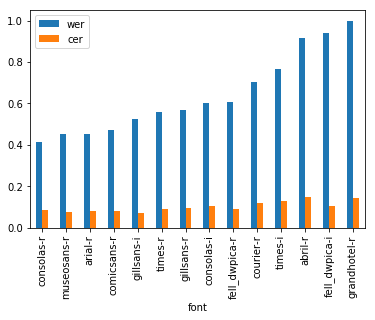

In [150]:
df = pandas.read_csv("fonts-results.csv", index_col=0)
df.groupby("font").mean()[["wer","cer"]].sort_values(by=["wer"]).plot.bar(y=["wer","cer"])

In [ ]:
results.